## Autor: Fernando Ordinola

## Preliminares

> __Formulación del problema__:  El problema planteado es un problema de clasificación binaria supervisada donde se nos pide determinar si un procedimiento desencadena en arresto contando con variables de diferente naturaleza como discretas y continuas y con posibles variables que revelan de alguna forma cual fue el resultado por lo que representan un problema ya que en un caso hipotetico real, no se tendría esa ventaja, y nuestro modelo debe ser capaz de generalizar con la data que se tendría en un caso real.
>
>
> __Objetivo__: Lograr determinar con un alto nivel de certeza si un procedimiento dada la naturaleza de su procedimiento desecandenará en un arresto.
>
>
> __Implementación de la solución__: Se implementarán modelos de clasificación supervisada con un preprocesamiento previo de los datos que conllevará limpieza de datos, hallazgo de insights, corrección de errores en la data etc.

> __Métricas de desempeño__
>> - Exactitud
>> - Precisión
>> - Recall
>> - F1 Score (Se destacará ya que como se pudo observar la V.O posee un desbalance notable)

> __Modelos a utilizar__
>> - Logistic Regression
>> - Random Forest
>> - Gradient BoostingClassifier
>> - SVC
>> - DecisionTree

> __Estrategia de división de muestras__: Se usará train_test_split de la libreria Scikit-learn, La idea detrás de esta división es que el modelo se entrene con el conjunto de datos de entrenamiento y luego se pruebe con el conjunto de datos de prueba para medir su capacidad para generalizar a nuevos datos. De esta manera, podemos evitar el sobreajuste y la subestimación del modelo.

> __Tipo de preprocesamiento a utilizar__: El preprocesamiento que se aplicará consistirá principalmente de limpieza de datos, corrigiendo o eliminando datos notablemente atipicos que no se consideren dentro de lo usual, datos faltantes, erroneos, etc. recodificación de datos según sea necesario.

## Aspectos Computacionales

>Python 3.9.12

> Librerías a utilizar
> - pandas 1.4.2
> - numpy 1.21.5
> - matplotlib 3.5.1
> - seaborn 0.11.2
> - sklearn 1.0.2
> - joblib 1.2.0
> - regex  2022.3.15
> - geopandas 0.12.2 
> - shapely 2.0.1

> Módulo propio con funciones utilitarias: __functions.py__

In [93]:
import random
import re
from functools import reduce
from itertools import combinations

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msngo

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC

import functions as pyfuncs
import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = (10,7)

In [2]:
df = pd.read_csv('2009_1perc.csv').drop('Unnamed: 0', axis=1)
df_test = pd.read_csv('2010_1perc.csv').drop('Unnamed: 0', axis=1)

# Pre procesamiento de variables.



<html>_________________________________________________________________________________________________________________________ </html>

__Se elimina la variable arstoff__ ya que esta hace referencia a la razón de arrestos.
__Se elimina la variable detailcm__ ya que especifica datos posteriores al procedimiento, dando razón del arresto.
__Se elimina la variable offverb__ verbal statement dadó por el oficial

In [3]:
arrest_vars = ['arstoffn', 'detailcm', 'offverb']
df.drop(columns=arrest_vars, axis=1, inplace=True)
df_test.drop(columns=arrest_vars, axis=1, inplace=True)

<b>Variables del dataset que contienen solo un valor en todas las filas del dataset</b>, incluyendo las que contienen vacio ' ' en todo el dataset, estas se eliminarán ya que se consideran variables constantes y pueden causar problemas de colinealidad o sobreajuste, además se reduciría dimensionalidad del problema y posiblemente mejorar el rendimiento del modelo

In [4]:
one_value_columns = []

for col in df:
    if len(df[col].value_counts().keys()) == 1:
        one_value_columns.append(col)
        print(f'Columna: {col}, Valor: {df[col].value_counts().keys()[0]}, Frecuencia: {df[col].value_counts().values[0]}')

Columna: year, Valor: 2009, Frecuencia: 5812
Columna: compyear, Valor: 0, Frecuencia: 5812
Columna: comppct, Valor: 0, Frecuencia: 5812
Columna: adtlrept, Valor: N, Frecuencia: 5812
Columna: machgun, Valor: N, Frecuencia: 5812
Columna: othfeatr, Valor:  , Frecuencia: 5812
Columna: addrtyp, Valor: L, Frecuencia: 5812
Columna: rescode, Valor:  , Frecuencia: 5812
Columna: premtype, Valor:  , Frecuencia: 5812
Columna: aptnum, Valor:  , Frecuencia: 5812
Columna: state, Valor:  , Frecuencia: 5812
Columna: zip, Valor:  , Frecuencia: 5812
Columna: dettypcm, Valor: CM, Frecuencia: 5812
Columna: linecm, Valor: 1, Frecuencia: 5812


In [5]:
df.drop(columns=one_value_columns, axis=1, 
        inplace=True) #eliminamos todas las variables que contienen 1 solo valor en todo el df

df_test.drop(columns=one_value_columns, axis=1, 
        inplace=True) #eliminamos todas las variables que contienen 1 solo valor en todo el df

> Transformamos todas las columnas tipo object que contengan la clase 'Y' o 'N' a binario

In [6]:
count_ = 0
for col in df.select_dtypes('O'):
    if len(df[col].value_counts()) == 2:
        if 'N' and 'Y' in list(df[col].value_counts().keys()):
            count_ += 1
            df[col] = np.where(df[col] == 'Y', 1, 0)
            df_test[col] = np.where(df_test[col] == 'Y', 1, 0)
print(f"Cantidad de columnas recodificadas binarias que eran 'Y' o 'N': {count_}")

Cantidad de columnas recodificadas binarias que eran 'Y' o 'N': 56


> Ya las variables tipo object que quedan, como se puede ver también son binarias, pero en vez de contener "Y" o "N" contienen "A" o "1", posteriormente se pasaran a 1 o 0, con ohe.

Transformamos estas columnas númericas que venian como tipo object, y transformamos sus valores nulos a 0.

In [7]:
pyfuncs.clean_numeric_cols(df, ['xcoord', 'ycoord', 'post', 'beat'])
pyfuncs.clean_numeric_cols(df_test, ['xcoord', 'ycoord', 'post', 'beat'])

In [8]:
df_test.dropna(inplace=True) #Se eliminaron 2 filas por valores nulos

In [9]:
for col in df.select_dtypes('O'):
    if len(df[col].value_counts()) > 100:  
        print(col, len(df[col].value_counts()))
        df.drop(columns=col, axis=1, inplace=True)
        df_test.drop(columns=col, axis=1, inplace=True)

crimsusp 388
sumoffen 192
premname 562
addrnum 1431
stname 977
stinter 1595
crossst 1686


In [10]:
pyfuncs.clean_columns(df, {'officrid': 1, 'offshld': 1, 'sector': 'U', 'trhsloc': 'U'})
pyfuncs.clean_columns(df_test, {'officrid': 1, 'offshld': 1, 'sector': 'U', 'trhsloc': 'U'})

# EDA (Arstmade)

In [11]:
def couna_norm(df, column, w, h):
    fig, ax = plt.subplots(figsize= (w,h))

    sns.countplot(data=df, x=column)

    total = float(len(df))
    for p in ax.patches:
        height = p.get_height()
        ax.annotate('{:.1f}%'.format((height/total)*100), xy=(p.get_x() + p.get_width() / 2., height),
                    xytext=(0, 5), textcoords='offset points', ha='center', va='bottom', 
                    fontsize=12, fontweight='bold')

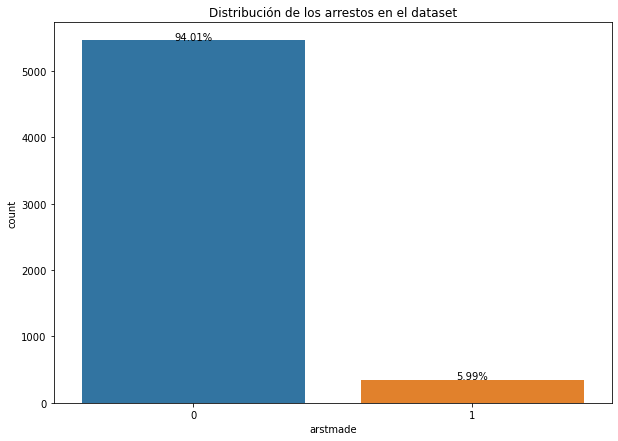

In [12]:
pyfuncs.countplot_with_percentages(df, 'arstmade', 'Distribución de los arrestos en el dataset')

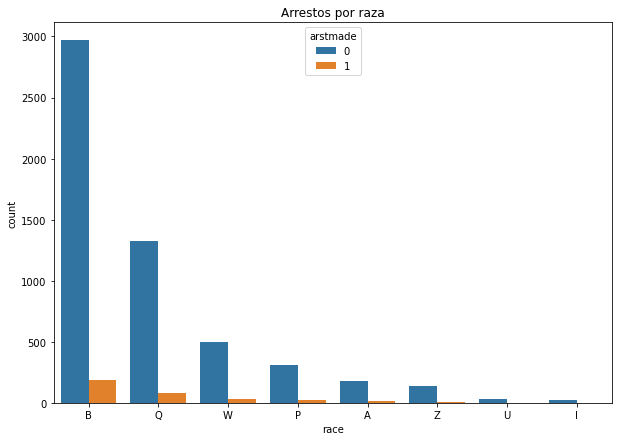

In [13]:
sns.countplot(data=df, x='race', hue='arstmade', order=df.race.value_counts().index)
plt.title('Arrestos por raza');

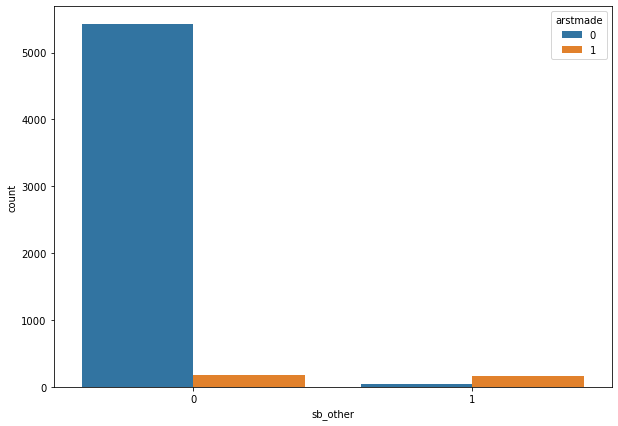

In [14]:
sns.countplot(data = df, x = 'sb_other', hue = 'arstmade');

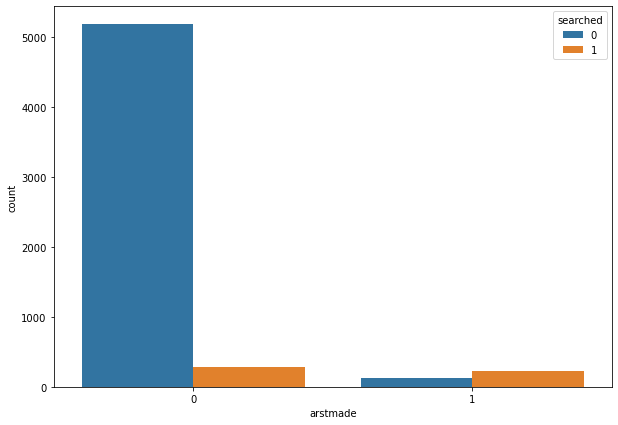

In [15]:
sns.countplot(data = df, x = 'arstmade', hue = 'searched');

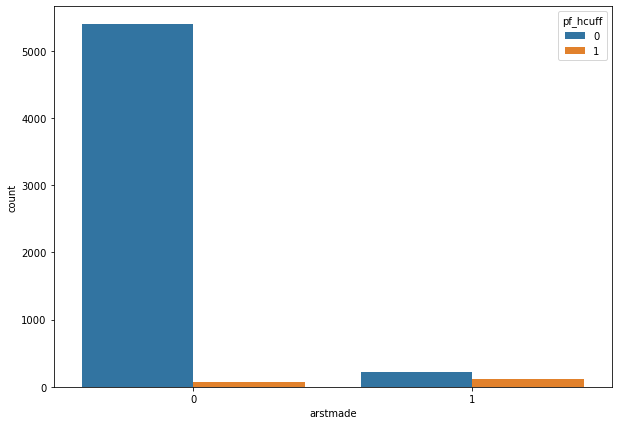

In [16]:
sns.countplot(data = df, x = 'arstmade', hue = 'pf_hcuff');

# Feature Engineering

Se ha detectado un patrón en los datos que sugiere que cuando se cumplen ciertos requisitos, hay una alta probabilidad de que se produzca un arresto. Estos requisitos incluyen ser de raza negra, tener más de 15 años y portar un tipo de arma distinto a las armas de fuego o aquellas descritas en otras variables.

Si bien no tiene mucha frecuencia en los datos este comportamiento, cuando sucede tiende a ser arresto siempre

In [17]:
df['othrweap_black_15'] = np.where((df['othrweap'] == 1) & (df['arstmade'] == 1) & (df['race'] == 'B') & (df['age'] > 15), 1, 0)
df_test['othrweap_black_15'] = np.where((df_test['othrweap'] == 1) & (df_test['arstmade'] == 1) & (df_test['race'] == 'B') & (df_test['age'] > 15), 1, 0)

Estas 3 variables tenian baja frecuencia, pero cada vez que sucedian era arresto en todas las ocasiones, por lo que se decide unir estas 3 en una sola variable, y llamarle "custom_var".

In [18]:
collected_variables = ['pistol', 'riflshot', 'asltweap']
pyfuncs.create_mask(df, df_test, 'custom_var', collected_variables)

"pf_hcuff" era una variable con bastante correlación y una frecuencia considerable, la que correspondia a las variables de la familia de pf_ que corresponde a variables asociadas con violencia, luego se contaba con "pf_baton" que si bien tenia poca frecuencia en el dataset tenia una alta correlación con arstmade, por lo que se adhiere esa variable a pf_hcuff y se crea una nueva variable pf_valuable_vars

In [19]:
pf_valuable_vars = ['pf_hcuff', 'pf_baton']
pyfuncs.create_mask(df, df_test, 'pf_valuable_vars', pf_valuable_vars)
df.drop(columns=pf_valuable_vars, axis=1, inplace=True)

Para concluir, se agregan dos variables con poca frecuencia a la variable con mayor correlación, lo que se denomina como "sb_other_plus". Al utilizar esta metodología, se emplean variables que, aunque tienen baja frecuencia en el conjunto de datos, ayudan a mejorar el desempeño de los modelos en términos de recall para la clase 1 y permiten una mayor precisión en la predicción de situaciones en las que se producirá un arresto.

In [20]:
sb_recod = ['sb_other', 'custom_var', 'othrweap_black_15']
pyfuncs.create_mask(df, df_test, 'sb_other_plus', sb_recod)
df.drop(columns=sb_recod, axis=1, inplace=True)

## Preparación de conjuntos

In [49]:
corr_vars = list(df.corr()['arstmade'].abs().sort_values(ascending=False).head(6).keys())[1:]

In [50]:
X_train = df.drop(columns='arstmade', axis=1)[corr_vars]
X_test = df_test.drop(columns='arstmade', axis=1)[corr_vars]

y_train = df['arstmade']
y_test = df_test['arstmade']

In [51]:
X_train = pyfuncs.scale_and_ohe(X_train)

In [52]:
X_test = pyfuncs.scale_and_ohe(X_test)

## Random forest (Arstmade)

In [53]:
rf = RandomForestClassifier(random_state=98)

In [63]:
param_grid = {'max_depth': [2,4,5,6,8,9,10], 'n_estimators': [50,100,150,200,250]}

cv_strat = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(rf, param_grid, cv=cv_strat, scoring='f1', n_jobs=-1)

grid.fit(X_train, y_train)

print(grid.best_params_)

{'max_depth': 4, 'n_estimators': 50}


> Se utiliza StratifiedKfold, dado el desbalance de la variable objetivo, esto ayuda a tener una misma proporción de la clase en cada conjunto, plus también ayuda a disminuir el tiempo de busqueda de hiper parametros.

In [55]:
rf = RandomForestClassifier(random_state=98, max_depth= 4, n_estimators= 50)

In [56]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, n_estimators=50, random_state=98)

In [57]:
importances = rf.feature_importances_
feature_importances = [(importance, feature) for feature, importance in zip(rf.feature_names_in_, importances)]

feature_importances = sorted(feature_importances, reverse=True)

for importance, feature in feature_importances[:500]:
    print(f'{feature}: {importance:.3f}')

sb_other_plus: 0.455
searched: 0.185
pf_valuable_vars: 0.163
contrabn: 0.160
rf_othsw: 0.038


In [58]:
y_pred = rf.predict(X_test)

In [59]:
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, digits=4))


Reporte de Clasificación:
              precision    recall  f1-score   support

           0     0.9752    0.9865    0.9808      5611
           1     0.7731    0.6475    0.7048       400

    accuracy                         0.9639      6011
   macro avg     0.8741    0.8170    0.8428      6011
weighted avg     0.9617    0.9639    0.9624      6011



> Es posible subir aún más la precisión de la clase 1 pero como consecuencia bajando el recall, esto se haría agregando más variables al modelo, pero en este caso especifico por criterio se elige tener un equilibrio donde el recall no se disminuya tanto por la naturaleza del problema, ya que cada vez que el procedimiento fuera a concretar en arresto queremos fallar lo menos posible cuando vaya a pasar un arresto.

## Gradient Boosting (Arstmade)

In [440]:
param_grid_gbl = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 150],
}

In [441]:
gbl = GradientBoostingClassifier(random_state=1)

In [442]:
grid_search = GridSearchCV(estimator=gbl, param_grid=param_grid_gbl, cv=5, scoring='f1')

In [443]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=1),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 150]},
             scoring='f1')

In [444]:
best_model = GradientBoostingClassifier(**grid_search.best_params_, random_state=1)
best_model

GradientBoostingClassifier(learning_rate=0.05, n_estimators=50, random_state=1)

In [445]:
best_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.05, n_estimators=50, random_state=1)

In [446]:
predictions_gbl = best_model.predict(X_test)

In [447]:
print('Mejores hiperparámetros:', grid_search.best_params_)

Mejores hiperparámetros: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}


In [448]:
print("\nReporte de Clasificación:")
print(classification_report(y_test, predictions_gbl, digits=4))


Reporte de Clasificación:
              precision    recall  f1-score   support

           0     0.9752    0.9865    0.9808      5611
           1     0.7731    0.6475    0.7048       400

    accuracy                         0.9639      6011
   macro avg     0.8741    0.8170    0.8428      6011
weighted avg     0.9617    0.9639    0.9624      6011



# Red neuronal (Arstmade)

In [64]:
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense

In [68]:
def create_model():
    model = Sequential() # modelo de red neuronal secuencial
    
    # Capa de entrada con 60 neuronas
    model.add(Dense(60, input_dim=5, activation='relu'))
    
    # Capa de salida con una neurona y función de activación sigmoide
    model.add(Dense(1, activation='sigmoid'))
    
    # Compilación del modelo con función de pérdida binary_crossentropy y optimizador Adam
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


In [101]:
nn = KerasClassifier(build_fn=create_model)

In [70]:
nn_model = nn.fit(X_train, y_train, epochs = 20, batch_size = 64, verbose = 1)

Epoch 1/20
91/91 [==============================] - 1s 2ms/step - loss: 0.4808 - accuracy: 0.9448
Epoch 2/20
91/91 [==============================] - 0s 2ms/step - loss: 0.2076 - accuracy: 0.9640
Epoch 3/20
91/91 [==============================] - 0s 2ms/step - loss: 0.1321 - accuracy: 0.9649
Epoch 4/20
91/91 [==============================] - 0s 2ms/step - loss: 0.1186 - accuracy: 0.9666
Epoch 5/20
91/91 [==============================] - 0s 1ms/step - loss: 0.1168 - accuracy: 0.9668
Epoch 6/20
91/91 [==============================] - 0s 2ms/step - loss: 0.1157 - accuracy: 0.9671
Epoch 7/20
91/91 [==============================] - 0s 1ms/step - loss: 0.1153 - accuracy: 0.9677
Epoch 8/20
91/91 [==============================] - 0s 1ms/step - loss: 0.1151 - accuracy: 0.9680
Epoch 9/20
91/91 [==============================] - 0s 1ms/step - loss: 0.1153 - accuracy: 0.9678
Epoch 10/20
91/91 [==============================] - 0s 2ms/step - loss: 0.1149 - accuracy: 0.9678
Epoch 11/20
91/91 [

<AxesSubplot:>

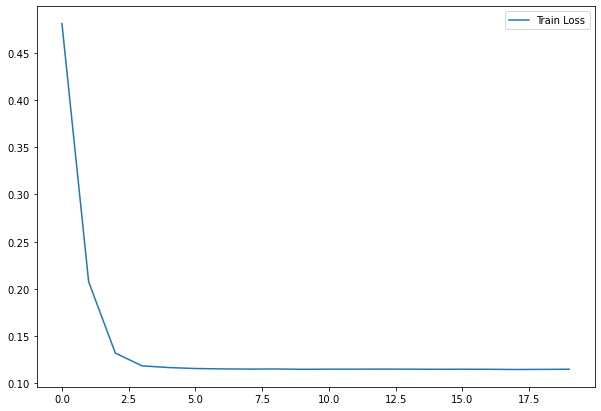

In [71]:
sns.lineplot(data = nn_model.history['loss'], label = 'Train Loss')

In [87]:
y_pred_prob = nn.model.predict(X_test)

188/188 [==============================] - 0s 1ms/step


In [102]:
thresholds = np.arange(0.1, 1.0, 0.1)

best_threshold = None
best_f1_score = 0.0

for threshold in thresholds:
    y_pr = (y_pred_prob > threshold).astype(int)
    report = classification_report(y_test, y_pr, digits=4, output_dict=True)
    f1_score_1 = report['1']['f1-score']
    mean_f1_score = f1_score_1

    if mean_f1_score > best_f1_score:
        best_f1_score = mean_f1_score
        best_threshold = threshold

print('Mejor umbral:', best_threshold)
print('Mejor F1-score:', best_f1_score)

Mejor umbral: 0.2
Mejor F1-score: 0.7053140096618358


In [ ]:
y_pred = (y_pred_prob > 0.2).astype(int)

Es importante considerar que este modelo de red neuronal se ejecutó como un experimento. Se encontró que este modelo tenía el mismo rendimiento que los demás modelos, pero en este caso se realizó un pequeño experimento iterando para encontrar el umbral de probabilidad en las predicciones que proporcionaba un mayor recall para la clase 1. Este experimento arrojó un umbral de 0.2 que se aplicó y se logró un rendimiento más equilibrado para la clase 1. Aunque esto sacrificó algo de precisión, se logró aumentar considerablemente el recall y se logró equilibrar ambas métricas para la clase 1.

In [96]:
print("Precisión en datos de prueba: ", accuracy_score(y_test, y_pred))

Precisión en datos de prueba:  0.9594077524538346


In [97]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9807    0.9758    0.9782      5611
           1     0.6822    0.7300    0.7053       400

    accuracy                         0.9594      6011
   macro avg     0.8314    0.8529    0.8418      6011
weighted avg     0.9608    0.9594    0.9600      6011



In [98]:
confusion_mtx = confusion_matrix(y_true=y_test, y_pred=y_pred)

In [99]:
from sklearn.metrics import confusion_matrix

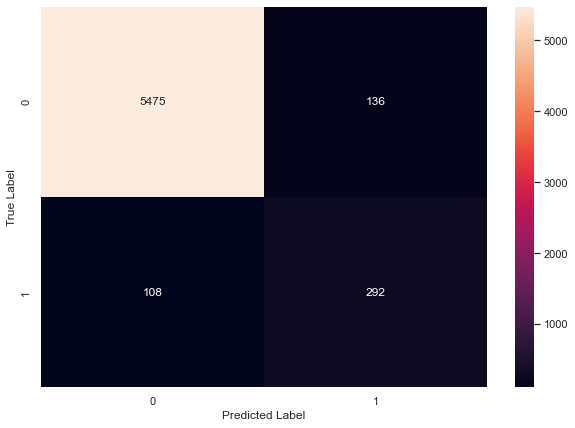

In [100]:
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()